# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [22]:
data_dir = './data'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

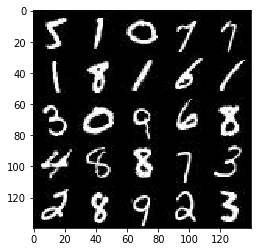

In [23]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

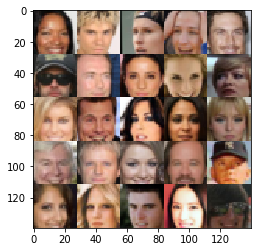

In [24]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [25]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [26]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='lr')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [27]:
def myconv2d(x, size):
    return tf.layers.conv2d(x, size, 5, strides=2, padding='same',
                            kernel_initializer=tf.contrib.layers.xavier_initializer())

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha=0.1
    training = not reuse
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = myconv2d(images, 64)
        relu1 = tf.maximum(alpha * x1, x1)
        #relu1 = tf.layers.dropout(relu1, rate=0.1, training=training)

        
        x2 = myconv2d(relu1, 128)
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #relu2 = tf.layers.dropout(relu2, rate=0.1, training=training)

        
        x3 = myconv2d(relu2, 256)
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        #relu3 = tf.layers.dropout(relu3, rate=0.1, training=training)


        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1, kernel_initializer=tf.contrib.layers.xavier_initializer())
        out = tf.sigmoid(logits)
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [28]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    reuse=not is_train
    alpha=0.1
    quantum=7
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, quantum*quantum*512, kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, quantum, quantum, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same', 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same', 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())   
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same', 
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [29]:
import numpy as np

def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real* np.random.uniform(0.7, 1.2))))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [30]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    deps = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    d_dep = [dep for dep in deps if dep.name.startswith("discriminator")]
    g_dep = [dep for dep in deps if dep.name.startswith("generator")]
    
    with tf.control_dependencies(d_dep):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    with tf.control_dependencies(g_dep):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [31]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [32]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    ## Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])            
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    print_every = 20
    show_every = 100
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                ## Train Model
                steps += 1
                
                # batch images mapped to -1, 1
                batch_images = batch_images*2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z, input_real: batch_images})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

            train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
            train_loss_g = g_loss.eval({input_z: batch_z, input_real: batch_images})
            print("Final of Epoch {}/{}...".format(epoch_i+1, epoch_count),
                  "Discriminator Loss: {:.4f}...".format(train_loss_d),
                  "Generator Loss: {:.4f}".format(train_loss_g))
            show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.1084... Generator Loss: 3.1126
Epoch 1/2... Discriminator Loss: 2.5611... Generator Loss: 3.1659
Epoch 1/2... Discriminator Loss: 1.5708... Generator Loss: 0.7097
Epoch 1/2... Discriminator Loss: 1.7355... Generator Loss: 0.7769
Epoch 1/2... Discriminator Loss: 1.6476... Generator Loss: 0.9273


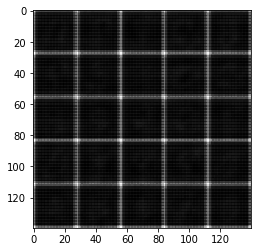

Epoch 1/2... Discriminator Loss: 1.3605... Generator Loss: 1.1292
Epoch 1/2... Discriminator Loss: 1.3957... Generator Loss: 1.0107
Epoch 1/2... Discriminator Loss: 1.2391... Generator Loss: 0.8909
Epoch 1/2... Discriminator Loss: 1.2096... Generator Loss: 1.1568
Epoch 1/2... Discriminator Loss: 1.0879... Generator Loss: 1.2187


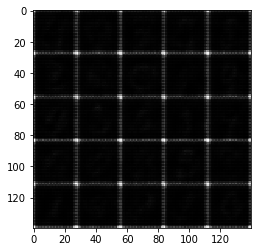

Epoch 1/2... Discriminator Loss: 1.3039... Generator Loss: 1.5418
Epoch 1/2... Discriminator Loss: 1.5692... Generator Loss: 0.2889
Epoch 1/2... Discriminator Loss: 1.3844... Generator Loss: 0.3967
Epoch 1/2... Discriminator Loss: 1.0374... Generator Loss: 1.1368
Epoch 1/2... Discriminator Loss: 1.1607... Generator Loss: 1.1925


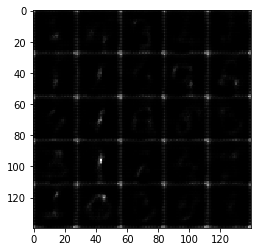

Epoch 1/2... Discriminator Loss: 1.1632... Generator Loss: 0.9124
Epoch 1/2... Discriminator Loss: 0.9387... Generator Loss: 1.5609
Epoch 1/2... Discriminator Loss: 1.3348... Generator Loss: 0.5318
Epoch 1/2... Discriminator Loss: 1.2177... Generator Loss: 1.1123
Epoch 1/2... Discriminator Loss: 1.2194... Generator Loss: 1.2877


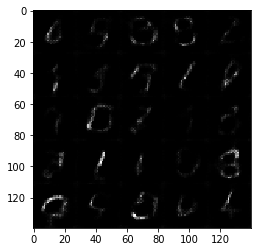

Epoch 1/2... Discriminator Loss: 1.2430... Generator Loss: 0.8467
Epoch 1/2... Discriminator Loss: 1.2439... Generator Loss: 1.0211
Epoch 1/2... Discriminator Loss: 1.2221... Generator Loss: 1.0545
Epoch 1/2... Discriminator Loss: 1.3167... Generator Loss: 1.1458
Epoch 1/2... Discriminator Loss: 1.0331... Generator Loss: 1.0079


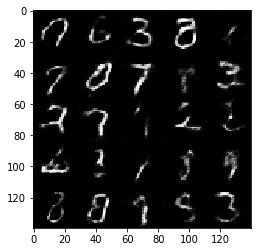

Epoch 1/2... Discriminator Loss: 1.2475... Generator Loss: 1.0323
Epoch 1/2... Discriminator Loss: 1.1747... Generator Loss: 0.7430
Epoch 1/2... Discriminator Loss: 1.2581... Generator Loss: 0.5073
Epoch 1/2... Discriminator Loss: 1.4014... Generator Loss: 0.4049
Epoch 1/2... Discriminator Loss: 1.1843... Generator Loss: 0.9102


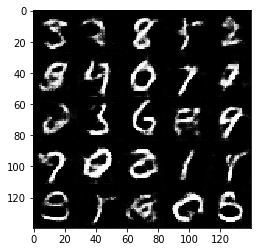

Epoch 1/2... Discriminator Loss: 1.4943... Generator Loss: 0.3308
Epoch 1/2... Discriminator Loss: 1.4260... Generator Loss: 0.3585
Epoch 1/2... Discriminator Loss: 1.1155... Generator Loss: 0.7652
Epoch 1/2... Discriminator Loss: 1.1878... Generator Loss: 1.1237
Epoch 1/2... Discriminator Loss: 1.1202... Generator Loss: 0.9166


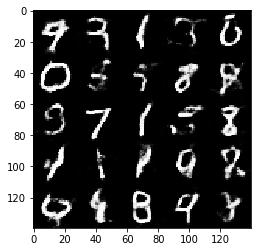

Epoch 1/2... Discriminator Loss: 1.3252... Generator Loss: 0.4662
Epoch 1/2... Discriminator Loss: 1.2512... Generator Loss: 0.5255
Epoch 1/2... Discriminator Loss: 1.4619... Generator Loss: 0.3662
Epoch 1/2... Discriminator Loss: 1.0735... Generator Loss: 0.7556
Epoch 1/2... Discriminator Loss: 1.2001... Generator Loss: 1.0151


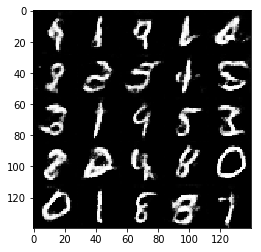

Epoch 1/2... Discriminator Loss: 1.0673... Generator Loss: 1.1015
Epoch 1/2... Discriminator Loss: 1.0844... Generator Loss: 1.3430
Epoch 1/2... Discriminator Loss: 1.2629... Generator Loss: 0.5105
Epoch 1/2... Discriminator Loss: 1.3258... Generator Loss: 0.4787
Epoch 1/2... Discriminator Loss: 1.1558... Generator Loss: 0.5589


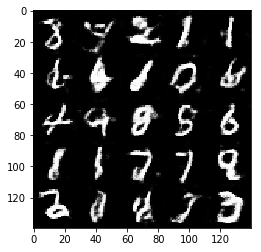

Epoch 1/2... Discriminator Loss: 1.9330... Generator Loss: 0.2182
Final of Epoch 1/2... Discriminator Loss: 1.0889... Generator Loss: 0.6721


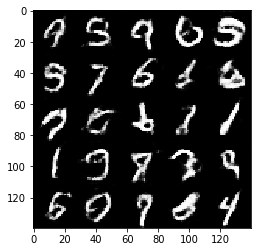

Epoch 2/2... Discriminator Loss: 1.4749... Generator Loss: 0.3558
Epoch 2/2... Discriminator Loss: 1.6263... Generator Loss: 0.2729
Epoch 2/2... Discriminator Loss: 1.1331... Generator Loss: 0.5943
Epoch 2/2... Discriminator Loss: 1.2403... Generator Loss: 0.4815
Epoch 2/2... Discriminator Loss: 1.2081... Generator Loss: 0.5026


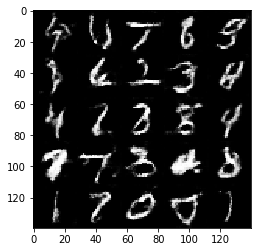

Epoch 2/2... Discriminator Loss: 1.0399... Generator Loss: 0.8381
Epoch 2/2... Discriminator Loss: 1.0399... Generator Loss: 0.7690
Epoch 2/2... Discriminator Loss: 1.2324... Generator Loss: 0.5074
Epoch 2/2... Discriminator Loss: 1.6748... Generator Loss: 0.2753
Epoch 2/2... Discriminator Loss: 0.9371... Generator Loss: 0.8271


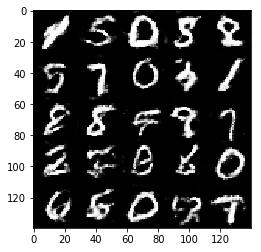

Epoch 2/2... Discriminator Loss: 1.2029... Generator Loss: 1.5394
Epoch 2/2... Discriminator Loss: 1.3692... Generator Loss: 0.3943
Epoch 2/2... Discriminator Loss: 0.9713... Generator Loss: 0.7935
Epoch 2/2... Discriminator Loss: 1.7077... Generator Loss: 0.2631
Epoch 2/2... Discriminator Loss: 1.1463... Generator Loss: 0.6055


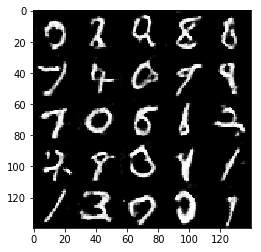

Epoch 2/2... Discriminator Loss: 1.6088... Generator Loss: 0.3491
Epoch 2/2... Discriminator Loss: 0.8367... Generator Loss: 0.9054
Epoch 2/2... Discriminator Loss: 1.3530... Generator Loss: 0.4059
Epoch 2/2... Discriminator Loss: 0.9899... Generator Loss: 0.7420
Epoch 2/2... Discriminator Loss: 1.3433... Generator Loss: 1.3454


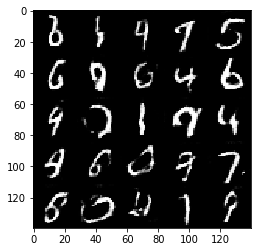

Epoch 2/2... Discriminator Loss: 0.9674... Generator Loss: 0.7167
Epoch 2/2... Discriminator Loss: 1.8711... Generator Loss: 0.2092
Epoch 2/2... Discriminator Loss: 1.0011... Generator Loss: 0.7865
Epoch 2/2... Discriminator Loss: 0.8777... Generator Loss: 1.0185
Epoch 2/2... Discriminator Loss: 2.3891... Generator Loss: 0.1497


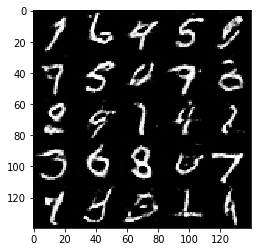

Epoch 2/2... Discriminator Loss: 1.0797... Generator Loss: 0.5730
Epoch 2/2... Discriminator Loss: 0.7582... Generator Loss: 2.1284
Epoch 2/2... Discriminator Loss: 2.2191... Generator Loss: 0.1730
Epoch 2/2... Discriminator Loss: 0.8103... Generator Loss: 1.0558
Epoch 2/2... Discriminator Loss: 1.1885... Generator Loss: 0.4856


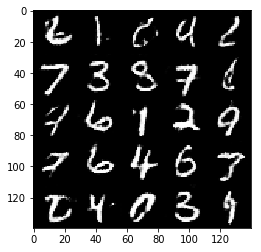

Epoch 2/2... Discriminator Loss: 0.7863... Generator Loss: 1.5218
Epoch 2/2... Discriminator Loss: 1.0038... Generator Loss: 1.6743
Epoch 2/2... Discriminator Loss: 0.9556... Generator Loss: 0.6461
Epoch 2/2... Discriminator Loss: 1.1607... Generator Loss: 0.5222
Epoch 2/2... Discriminator Loss: 1.3858... Generator Loss: 0.4432


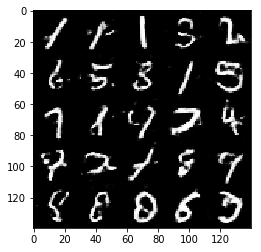

Epoch 2/2... Discriminator Loss: 0.8691... Generator Loss: 1.5114
Epoch 2/2... Discriminator Loss: 0.7051... Generator Loss: 1.2886
Epoch 2/2... Discriminator Loss: 0.8591... Generator Loss: 0.7926
Epoch 2/2... Discriminator Loss: 1.5201... Generator Loss: 0.3194
Epoch 2/2... Discriminator Loss: 0.8667... Generator Loss: 0.8826


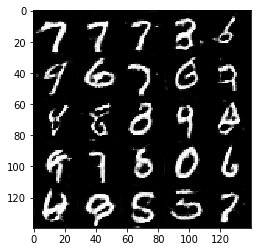

Epoch 2/2... Discriminator Loss: 0.7945... Generator Loss: 1.2377
Epoch 2/2... Discriminator Loss: 0.6079... Generator Loss: 1.4220
Epoch 2/2... Discriminator Loss: 1.6441... Generator Loss: 0.2847
Epoch 2/2... Discriminator Loss: 0.7965... Generator Loss: 0.8695
Epoch 2/2... Discriminator Loss: 0.8931... Generator Loss: 0.7252


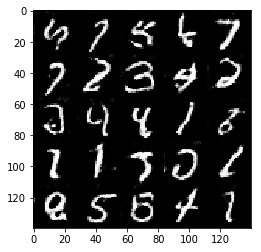

Epoch 2/2... Discriminator Loss: 0.8341... Generator Loss: 0.7998
Final of Epoch 2/2... Discriminator Loss: 1.0066... Generator Loss: 0.6379


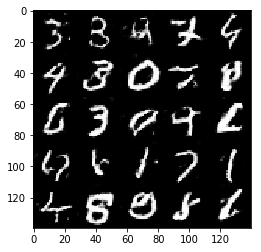

In [ ]:
batch_size = 64
z_dim = 100
beta1 = 0.1
learning_rate = 0.0002

tf.reset_default_graph()


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.2415... Generator Loss: 5.0786
Epoch 1/1... Discriminator Loss: 1.1857... Generator Loss: 2.8155
Epoch 1/1... Discriminator Loss: 1.0056... Generator Loss: 3.5375
Epoch 1/1... Discriminator Loss: 1.7163... Generator Loss: 5.4531
Epoch 1/1... Discriminator Loss: 0.2989... Generator Loss: 3.7985


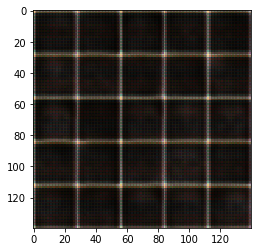

Epoch 1/1... Discriminator Loss: 0.5089... Generator Loss: 4.4750
Epoch 1/1... Discriminator Loss: 0.9203... Generator Loss: 0.6871
Epoch 1/1... Discriminator Loss: 1.9803... Generator Loss: 0.2191
Epoch 1/1... Discriminator Loss: 0.4950... Generator Loss: 2.1429
Epoch 1/1... Discriminator Loss: 0.5351... Generator Loss: 2.2198


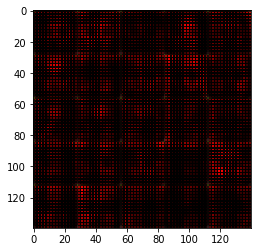

Epoch 1/1... Discriminator Loss: 1.0160... Generator Loss: 0.5602
Epoch 1/1... Discriminator Loss: 0.7060... Generator Loss: 2.6753
Epoch 1/1... Discriminator Loss: 0.8148... Generator Loss: 0.8333
Epoch 1/1... Discriminator Loss: 1.1707... Generator Loss: 0.9570
Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 1.9735


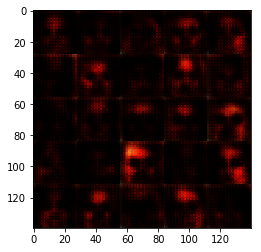

Epoch 1/1... Discriminator Loss: 0.6918... Generator Loss: 1.6264
Epoch 1/1... Discriminator Loss: 1.4350... Generator Loss: 1.7687
Epoch 1/1... Discriminator Loss: 1.4170... Generator Loss: 0.3657
Epoch 1/1... Discriminator Loss: 0.7421... Generator Loss: 1.1401
Epoch 1/1... Discriminator Loss: 0.9784... Generator Loss: 0.6533


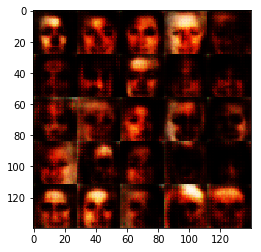

Epoch 1/1... Discriminator Loss: 1.6576... Generator Loss: 0.2671
Epoch 1/1... Discriminator Loss: 1.2015... Generator Loss: 0.4813
Epoch 1/1... Discriminator Loss: 0.9083... Generator Loss: 2.2064
Epoch 1/1... Discriminator Loss: 0.6086... Generator Loss: 1.1213
Epoch 1/1... Discriminator Loss: 1.2309... Generator Loss: 0.4413


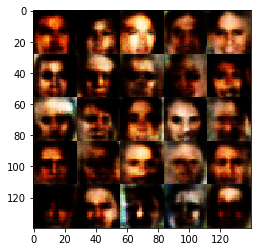

Epoch 1/1... Discriminator Loss: 0.8273... Generator Loss: 0.8860
Epoch 1/1... Discriminator Loss: 1.4731... Generator Loss: 2.7844
Epoch 1/1... Discriminator Loss: 0.6849... Generator Loss: 0.9055
Epoch 1/1... Discriminator Loss: 0.6892... Generator Loss: 0.9033
Epoch 1/1... Discriminator Loss: 0.3918... Generator Loss: 2.3436


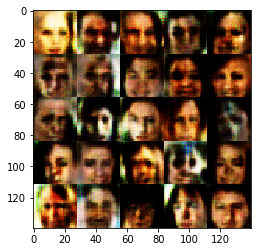

Epoch 1/1... Discriminator Loss: 0.6722... Generator Loss: 0.9184
Epoch 1/1... Discriminator Loss: 0.6288... Generator Loss: 1.1338
Epoch 1/1... Discriminator Loss: 0.6995... Generator Loss: 2.0599
Epoch 1/1... Discriminator Loss: 1.9942... Generator Loss: 0.1811
Epoch 1/1... Discriminator Loss: 1.3489... Generator Loss: 1.5257


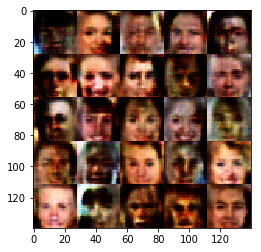

Epoch 1/1... Discriminator Loss: 0.5242... Generator Loss: 2.1734
Epoch 1/1... Discriminator Loss: 1.1583... Generator Loss: 1.3948
Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 0.3931
Epoch 1/1... Discriminator Loss: 0.6812... Generator Loss: 1.8012
Epoch 1/1... Discriminator Loss: 0.3581... Generator Loss: 1.6899


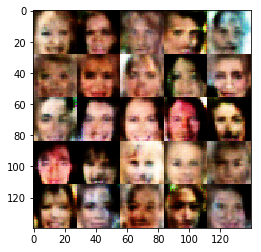

Epoch 1/1... Discriminator Loss: 0.5284... Generator Loss: 2.0955
Epoch 1/1... Discriminator Loss: 0.4105... Generator Loss: 2.6659
Epoch 1/1... Discriminator Loss: 0.8095... Generator Loss: 0.7502
Epoch 1/1... Discriminator Loss: 1.2287... Generator Loss: 0.5932
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.3910


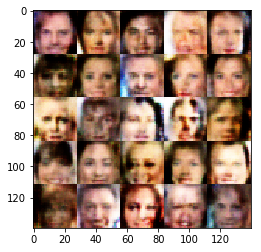

Epoch 1/1... Discriminator Loss: 1.4249... Generator Loss: 0.3460
Epoch 1/1... Discriminator Loss: 0.7717... Generator Loss: 0.7958
Epoch 1/1... Discriminator Loss: 0.8179... Generator Loss: 0.8836
Epoch 1/1... Discriminator Loss: 0.7681... Generator Loss: 0.7727
Epoch 1/1... Discriminator Loss: 1.3114... Generator Loss: 1.4756


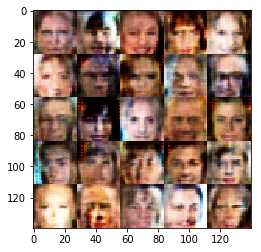

Epoch 1/1... Discriminator Loss: 0.5709... Generator Loss: 1.0727
Epoch 1/1... Discriminator Loss: 0.9276... Generator Loss: 0.7731
Epoch 1/1... Discriminator Loss: 1.2061... Generator Loss: 1.9332
Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 1.0026
Epoch 1/1... Discriminator Loss: 0.5473... Generator Loss: 1.6113


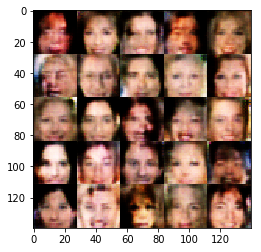

Epoch 1/1... Discriminator Loss: 0.8367... Generator Loss: 0.6928
Epoch 1/1... Discriminator Loss: 1.2709... Generator Loss: 1.0040
Epoch 1/1... Discriminator Loss: 0.8585... Generator Loss: 0.8013
Epoch 1/1... Discriminator Loss: 0.5493... Generator Loss: 1.4318
Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.8263


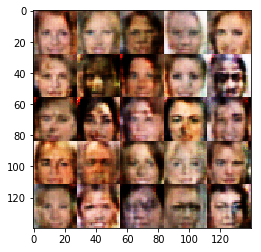

Epoch 1/1... Discriminator Loss: 0.6576... Generator Loss: 1.7162
Epoch 1/1... Discriminator Loss: 1.9450... Generator Loss: 1.4182
Epoch 1/1... Discriminator Loss: 1.1560... Generator Loss: 0.5492
Epoch 1/1... Discriminator Loss: 1.2906... Generator Loss: 0.4198
Epoch 1/1... Discriminator Loss: 1.2648... Generator Loss: 0.6606


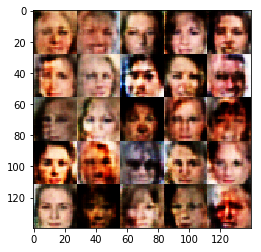

Epoch 1/1... Discriminator Loss: 0.7644... Generator Loss: 1.9438
Epoch 1/1... Discriminator Loss: 1.2054... Generator Loss: 1.2098
Epoch 1/1... Discriminator Loss: 1.7673... Generator Loss: 0.2297
Epoch 1/1... Discriminator Loss: 1.2923... Generator Loss: 0.4415
Epoch 1/1... Discriminator Loss: 0.6218... Generator Loss: 1.3305


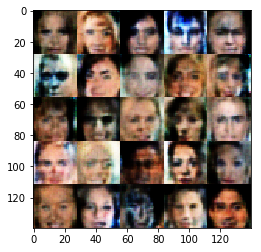

Epoch 1/1... Discriminator Loss: 1.0964... Generator Loss: 0.7908
Epoch 1/1... Discriminator Loss: 0.8335... Generator Loss: 1.1440
Epoch 1/1... Discriminator Loss: 0.9773... Generator Loss: 0.7673
Epoch 1/1... Discriminator Loss: 0.8234... Generator Loss: 1.3898
Epoch 1/1... Discriminator Loss: 1.7637... Generator Loss: 0.2266


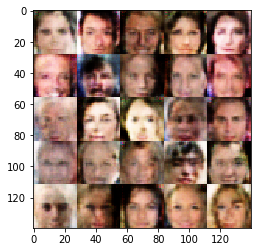

Epoch 1/1... Discriminator Loss: 0.9775... Generator Loss: 0.6357
Epoch 1/1... Discriminator Loss: 1.1322... Generator Loss: 0.5993
Epoch 1/1... Discriminator Loss: 0.8007... Generator Loss: 1.8896
Epoch 1/1... Discriminator Loss: 0.8892... Generator Loss: 0.7393
Epoch 1/1... Discriminator Loss: 1.0897... Generator Loss: 0.5362


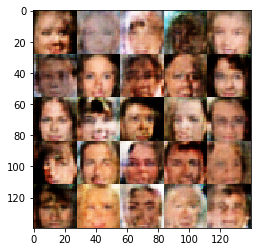

Epoch 1/1... Discriminator Loss: 1.0230... Generator Loss: 0.6530
Epoch 1/1... Discriminator Loss: 0.5907... Generator Loss: 1.6396
Epoch 1/1... Discriminator Loss: 1.6102... Generator Loss: 0.2827
Epoch 1/1... Discriminator Loss: 0.4865... Generator Loss: 3.0589
Epoch 1/1... Discriminator Loss: 1.3618... Generator Loss: 0.3903


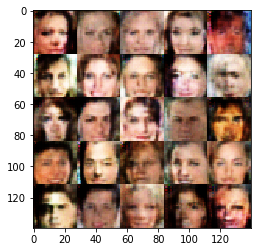

Epoch 1/1... Discriminator Loss: 1.2225... Generator Loss: 1.0383
Epoch 1/1... Discriminator Loss: 1.9927... Generator Loss: 0.1787
Epoch 1/1... Discriminator Loss: 0.4667... Generator Loss: 1.2703
Epoch 1/1... Discriminator Loss: 1.3457... Generator Loss: 0.4207
Epoch 1/1... Discriminator Loss: 0.8638... Generator Loss: 0.8216


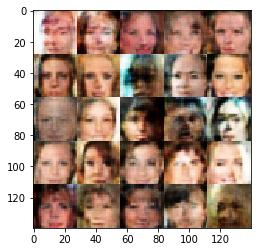

Epoch 1/1... Discriminator Loss: 1.0488... Generator Loss: 0.5773
Epoch 1/1... Discriminator Loss: 1.4240... Generator Loss: 1.6747
Epoch 1/1... Discriminator Loss: 1.6145... Generator Loss: 0.2940
Epoch 1/1... Discriminator Loss: 1.3339... Generator Loss: 0.5676
Epoch 1/1... Discriminator Loss: 0.5772... Generator Loss: 1.1970


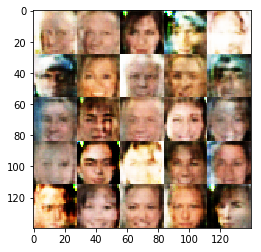

Epoch 1/1... Discriminator Loss: 0.6107... Generator Loss: 1.2152
Epoch 1/1... Discriminator Loss: 1.6057... Generator Loss: 0.2939
Epoch 1/1... Discriminator Loss: 0.6826... Generator Loss: 1.0867
Epoch 1/1... Discriminator Loss: 1.1799... Generator Loss: 0.4945
Epoch 1/1... Discriminator Loss: 0.7320... Generator Loss: 0.8929


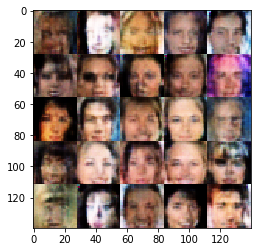

Epoch 1/1... Discriminator Loss: 1.9799... Generator Loss: 0.1883
Epoch 1/1... Discriminator Loss: 0.7062... Generator Loss: 1.0994
Epoch 1/1... Discriminator Loss: 0.8002... Generator Loss: 0.8174
Epoch 1/1... Discriminator Loss: 1.2482... Generator Loss: 0.9569
Epoch 1/1... Discriminator Loss: 0.4868... Generator Loss: 1.5251


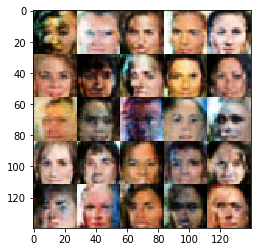

Epoch 1/1... Discriminator Loss: 1.2319... Generator Loss: 1.1569
Epoch 1/1... Discriminator Loss: 1.3317... Generator Loss: 1.1340
Epoch 1/1... Discriminator Loss: 1.2776... Generator Loss: 0.5359
Epoch 1/1... Discriminator Loss: 0.5707... Generator Loss: 1.5362
Epoch 1/1... Discriminator Loss: 1.7878... Generator Loss: 0.2431


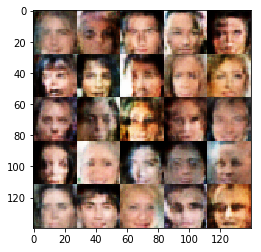

Epoch 1/1... Discriminator Loss: 1.7504... Generator Loss: 0.2390
Epoch 1/1... Discriminator Loss: 0.5066... Generator Loss: 1.6516
Epoch 1/1... Discriminator Loss: 1.4922... Generator Loss: 0.3341
Epoch 1/1... Discriminator Loss: 1.0768... Generator Loss: 1.4016
Epoch 1/1... Discriminator Loss: 1.3293... Generator Loss: 0.5583


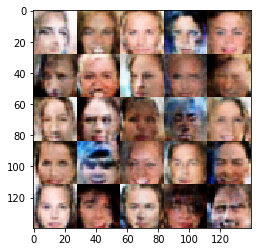

Epoch 1/1... Discriminator Loss: 1.0264... Generator Loss: 1.8280
Epoch 1/1... Discriminator Loss: 1.1959... Generator Loss: 1.9767
Epoch 1/1... Discriminator Loss: 0.5939... Generator Loss: 1.2578
Epoch 1/1... Discriminator Loss: 2.8350... Generator Loss: 2.4812
Epoch 1/1... Discriminator Loss: 1.1433... Generator Loss: 1.0176


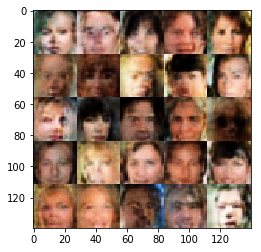

Epoch 1/1... Discriminator Loss: 1.4880... Generator Loss: 1.1282
Epoch 1/1... Discriminator Loss: 0.9075... Generator Loss: 0.7135
Epoch 1/1... Discriminator Loss: 1.3623... Generator Loss: 1.9618
Epoch 1/1... Discriminator Loss: 0.5999... Generator Loss: 1.2832
Epoch 1/1... Discriminator Loss: 1.0029... Generator Loss: 0.6632


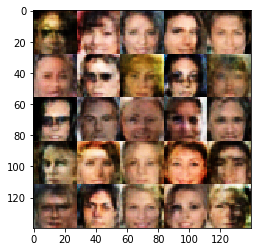

Epoch 1/1... Discriminator Loss: 1.4857... Generator Loss: 0.5778
Epoch 1/1... Discriminator Loss: 0.6839... Generator Loss: 1.5301
Epoch 1/1... Discriminator Loss: 0.9129... Generator Loss: 1.3012
Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.6142
Epoch 1/1... Discriminator Loss: 0.8676... Generator Loss: 0.8458


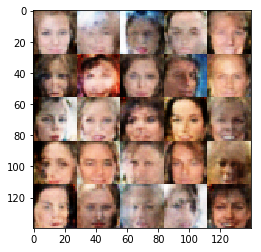

Epoch 1/1... Discriminator Loss: 0.6407... Generator Loss: 2.3487
Epoch 1/1... Discriminator Loss: 1.0171... Generator Loss: 1.3231
Epoch 1/1... Discriminator Loss: 2.0547... Generator Loss: 1.9841
Epoch 1/1... Discriminator Loss: 1.2000... Generator Loss: 1.7232
Epoch 1/1... Discriminator Loss: 0.5242... Generator Loss: 1.7133


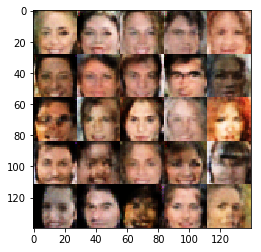

Epoch 1/1... Discriminator Loss: 0.8753... Generator Loss: 1.3263
Epoch 1/1... Discriminator Loss: 0.8008... Generator Loss: 0.8524
Epoch 1/1... Discriminator Loss: 1.1041... Generator Loss: 0.7179
Epoch 1/1... Discriminator Loss: 0.9946... Generator Loss: 1.0598
Epoch 1/1... Discriminator Loss: 0.7748... Generator Loss: 1.7294


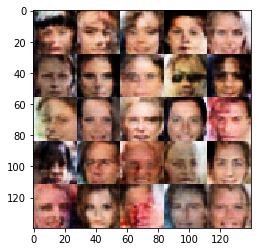

Epoch 1/1... Discriminator Loss: 0.9014... Generator Loss: 0.8297
Epoch 1/1... Discriminator Loss: 0.9730... Generator Loss: 0.9353
Epoch 1/1... Discriminator Loss: 1.4756... Generator Loss: 1.3202
Epoch 1/1... Discriminator Loss: 0.8704... Generator Loss: 0.6995
Epoch 1/1... Discriminator Loss: 0.7853... Generator Loss: 0.8548


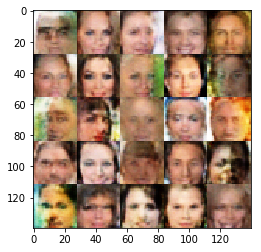

Epoch 1/1... Discriminator Loss: 1.6321... Generator Loss: 1.2481
Epoch 1/1... Discriminator Loss: 0.5628... Generator Loss: 1.3071
Epoch 1/1... Discriminator Loss: 1.2128... Generator Loss: 0.4424
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.4248
Epoch 1/1... Discriminator Loss: 1.5585... Generator Loss: 0.2982


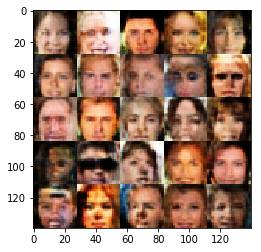

Epoch 1/1... Discriminator Loss: 0.5310... Generator Loss: 1.7063
Epoch 1/1... Discriminator Loss: 1.3639... Generator Loss: 0.4759
Epoch 1/1... Discriminator Loss: 1.0427... Generator Loss: 0.8505
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1759... Generator Loss: 0.5742


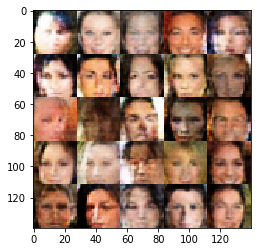

Epoch 1/1... Discriminator Loss: 1.7951... Generator Loss: 1.3582
Epoch 1/1... Discriminator Loss: 1.5980... Generator Loss: 0.3030


In [ ]:
z_dim = 100
batch_size = 64
beta1 = 0.1
learning_rate = 0.0002

tf.reset_default_graph()


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.